# Food Delivery Data Insights
Author: Raghupathi

This notebook explores and analyzes an online food delivery dataset by
integrating transactional, user, and restaurant data from CSV, JSON,
and SQL sources to derive meaningful business insights and visualizations.


In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")


orders = pd.read_csv("orders.csv")
orders.head()


,order_id,user_id,restaurant_id,order_date,total_amount,restaurant_name
0,1,2508,450,18-02-2023,842.97,New Foods Chinese
1,2,2693,309,18-01-2023,546.68,Ruchi Curry House Multicuisine
2,3,2084,107,15-07-2023,163.93,Spice Kitchen Punjabi
3,4,319,224,04-10-2023,1155.97,Darbar Kitchen Non-Veg
4,5,1064,293,25-12-2023,1321.91,Royal Eatery South Indian


In [2]:
users = pd.read_json("users.json")
users.head()


,user_id,name,city,membership
0,1,User_1,Chennai,Regular
1,2,User_2,Pune,Gold
2,3,User_3,Bangalore,Gold
3,4,User_4,Bangalore,Regular
4,5,User_5,Pune,Gold


In [4]:
import sqlite3

conn = sqlite3.connect(":memory:")
cursor = conn.cursor()

with open("restaurants.sql", "r") as f:
    sql_script = f.read()

cursor.executescript(sql_script)

restaurants = pd.read_sql("SELECT * FROM restaurants", conn)
restaurants.head()


,restaurant_id,restaurant_name,cuisine,rating
0,1,Restaurant_1,Chinese,4.8
1,2,Restaurant_2,Indian,4.1
2,3,Restaurant_3,Mexican,4.3
3,4,Restaurant_4,Chinese,4.1
4,5,Restaurant_5,Chinese,4.8


In [7]:
df = orders.merge(users, on="user_id", how="left")


In [8]:
df = df.merge(restaurants, on="restaurant_id", how="left")


In [9]:
df["order_date"] = pd.to_datetime(df["order_date"])


C:\Users\raghu\AppData\Local\Temp\ipykernel_9668\760424543.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["order_date"] = pd.to_datetime(df["order_date"])


In [10]:
df["month"] = df["order_date"].dt.month
df["quarter"] = df["order_date"].dt.to_period("Q").astype(str)


In [14]:
df.to_csv("final_food_delivery_dataset.csv", index=False)


In [18]:
df.columns

Index(['order_id', 'user_id', 'restaurant_id', 'order_date', 'total_amount',
       'restaurant_name_x', 'name', 'city', 'membership', 'restaurant_name_y',
       'cuisine', 'rating', 'month', 'quarter'],
      dtype='object')

In [19]:
df[df["membership"]=="Gold"] \
.groupby("city")["total_amount"].sum() \
.sort_values(ascending=False)


city
Chennai      1080909.79
Pune         1003012.32
Bangalore     994702.59
Hyderabad     896740.19
Name: total_amount, dtype: float64

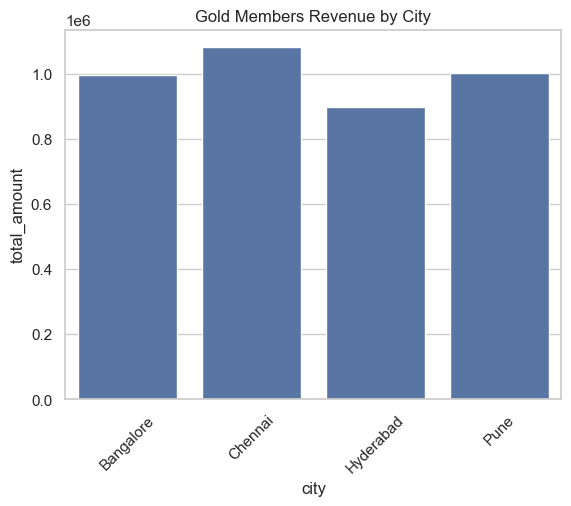

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

gold_city_revenue = (
    df[df["membership"] == "Gold"]
    .groupby("city")["total_amount"]
    .sum()
    .reset_index()
)

sns.barplot(
    data=gold_city_revenue,
    x="city",
    y="total_amount"
)

plt.title("Gold Members Revenue by City")
plt.xticks(rotation=45)
plt.show()




In [20]:
df.groupby("cuisine")["total_amount"].mean() \
.sort_values(ascending=False)


cuisine
Mexican    808.021344
Italian    799.448578
Indian     798.466011
Chinese    798.389020
Name: total_amount, dtype: float64

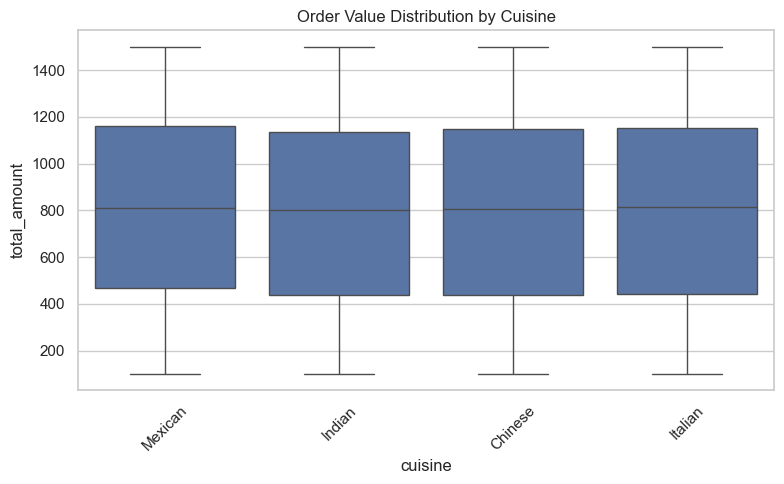

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

sns.boxplot(
    data=df,
    x="cuisine",
    y="total_amount"
)

plt.title("Order Value Distribution by Cuisine")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [21]:
user_spend = df.groupby("user_id")["total_amount"].sum()
(user_spend > 1000).sum()


np.int64(2544)

In [22]:
df["rating_range"] = pd.cut(
    df["rating"],
    bins=[3.0,3.5,4.0,4.5,5.0],
    labels=["3.0–3.5","3.6–4.0","4.1–4.5","4.6–5.0"]
)

df.groupby("rating_range")["total_amount"].sum() \
.sort_values(ascending=False)


C:\Users\raghu\AppData\Local\Temp\ipykernel_9668\1459667625.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("rating_range")["total_amount"].sum() \


rating_range
4.6–5.0    2197030.75
4.1–4.5    1960326.26
3.0–3.5    1881754.57
3.6–4.0    1717494.41
Name: total_amount, dtype: float64

In [23]:
df[df["membership"]=="Gold"] \
.groupby("city")["total_amount"].mean() \
.sort_values(ascending=False)


city
Chennai      808.459080
Hyderabad    806.421034
Bangalore    793.223756
Pune         781.162243
Name: total_amount, dtype: float64

In [24]:
restaurant_count = df.groupby("cuisine")["restaurant_id"].nunique()
revenue = df.groupby("cuisine")["total_amount"].sum()

pd.concat([restaurant_count, revenue], axis=1) \
.rename(columns={"restaurant_id":"restaurant_count"}) \
.sort_values(by=["restaurant_count","total_amount"])


,restaurant_count,total_amount
cuisine,,
Chinese,120,1930504.65
Indian,126,1971412.58
Italian,126,2024203.80
Mexican,128,2085503.09


In [26]:
gold_orders = df[df["membership"]=="Gold"].shape[0]
total_orders = df.shape[0]

round((gold_orders/total_orders)*100)


50

In [28]:
restaurant_stats = df.groupby("restaurant_name_x").agg(
    avg_order=("total_amount","mean"),
    order_count=("order_id","count")
)

restaurant_stats[restaurant_stats["order_count"] < 20] \
.sort_values("avg_order", ascending=False)


,avg_order,order_count
restaurant_name_x,,
Hotel Dhaba Multicuisine,1040.222308,13
Sri Mess Punjabi,1029.180833,12
Ruchi Biryani Punjabi,1002.140625,16
Sri Delights Pure Veg,989.467222,18
Classic Kitchen Family Restaurant,973.167895,19
...,...,...
Annapurna Tiffins Punjabi,621.828947,19
Darbar Tiffins Non-Veg,596.815556,18
Darbar Restaurant Punjabi,589.972857,14


In [30]:
df.groupby(["membership","cuisine"])["total_amount"].sum() \
.sort_values(ascending=False)


membership  cuisine
Regular     Mexican    1072943.30
            Italian    1018424.75
Gold        Mexican    1012559.79
            Italian    1005779.05
Regular     Indian      992100.27
Gold        Indian      979312.31
            Chinese     977713.74
Regular     Chinese     952790.91
Name: total_amount, dtype: float64

In [31]:
df.groupby("quarter")["total_amount"].sum() \
.sort_values(ascending=False)


quarter
2023Q3    2037385.10
2023Q4    2018263.66
2023Q1    1993425.14
2023Q2    1945348.72
2024Q1      17201.50
Name: total_amount, dtype: float64

In [32]:
df[df["membership"] == "Gold"].shape[0]


4987

In [33]:
round(
    df[df["city"] == "Hyderabad"]["total_amount"].sum()
)


1889367

In [34]:
df["user_id"].nunique()


2883

In [35]:
round(
    df[df["membership"] == "Gold"]["total_amount"].mean(),
    2
)


np.float64(797.15)

In [36]:
df[df["rating"] >= 4.5].shape[0]



3374

In [37]:
top_city = (
    df[df["membership"] == "Gold"]
    .groupby("city")["total_amount"]
    .sum()
    .sort_values(ascending=False)
    .index[0]
)

top_city
df[
    (df["membership"] == "Gold") &
    (df["city"] == top_city)
].shape[0]


1337